In [1]:
# from update_data import *
from static import *
from stock_data import *
import bao
from AR import *
from MA import *
from scipy.stats.mstats import winsorize  # type: ignore


stock = StockData("./data/stock/", "./stock_dictionary.json")
stock_data, market = stock.get_data()

## winsorize the outliner

In [2]:
market_winsored = pd.DataFrame()
for i in market["exchange"].unique():
    temp = market.loc[market["exchange"] == i].copy()
    temp["return_weighted"] = winsorize(temp["return"], limits=[0.05, 0.05])
    temp["log_return"] = winsorize(temp["log_return"], limits=[0.05, 0.05])
    market_winsored = pd.concat([market_winsored, temp], axis=0)
    # Detect outliers using Z-score
del temp

# test stationary

In [3]:
from test_and_visualize import *

In [4]:
test_stationarity(market_winsored)

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



Exchange  ADF_Statistic   ADF_p_value  ADF_Critical_1%  ADF_Critical_5%  \
0  DELISTED      -7.053969  5.435303e-10        -3.432995        -2.862708   
1       HNX      -9.945960  2.589286e-17        -3.432544        -2.862509   
2       HSX     -13.877891  6.289208e-26        -3.432539        -2.862507   
3     UPCOM     -11.591940  2.778373e-21        -3.432541        -2.862508   
4      vn30     -28.391002  0.000000e+00        -3.433901        -2.863109   
5       vni     -29.530338  0.000000e+00        -3.432534        -2.862505   

   ADF_Critical_10%  ADF_Result  KPSS_Statistic  KPSS_p_value  \
0         -2.567392  Stationary        1.427743          0.01   
1         -2.567286  Stationary        0.164558          0.10   
2         -2.567285  Stationary        0.068832          0.10   
3         -2.567285  Stationary        0.231317          0.10   
4         -2.567605  Stationary        0.201567          0.10   
5         -2.567284  Stationary        0.076274          0.10   

   KPSS_Critical_1%  KPSS_Critical_5%  KPSS_Critical_10%     KPSS_Result  
0             0.739             0.463              0.347  Non-stationary  
1             0.739             0.463              0.347      Stationary  
2             0.739             0.463              0.347      Stationary  
3             0.739             0.463              0.347      Stationary  
4             0.739             0.463              0.347      Stationary  
5             0.739             0.463              0.347      Stationary

# Seasonarity

* with the cycle is 2 year: the trend is more observable

HNX


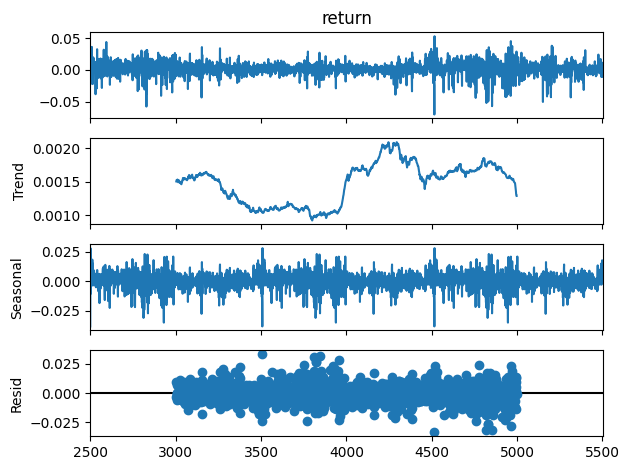

HSX


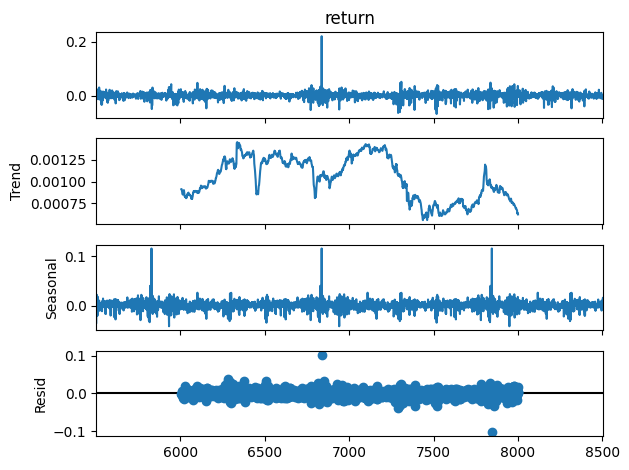

UPCOM


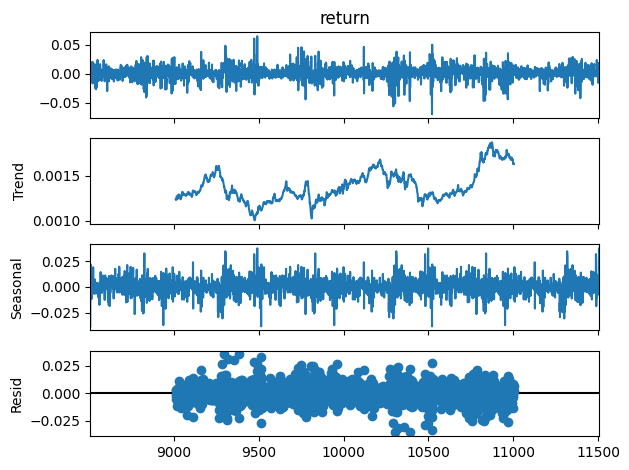

vn30
plot 1 year cycles


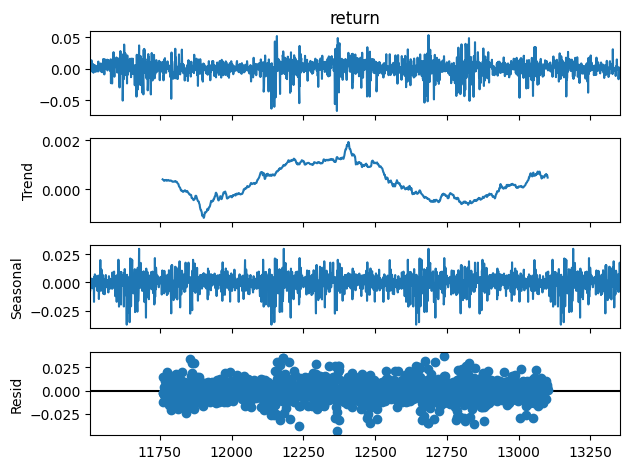

vni


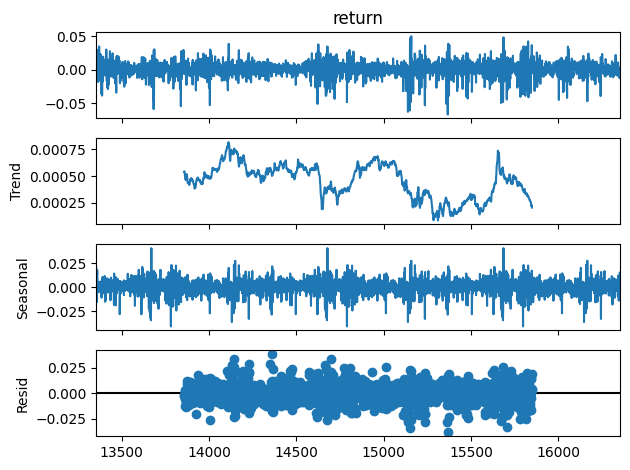

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

period = 2
for i in market["ticker"].unique():
    if i not in ["BOND", "DELISTED"]:
        print(i)
        try:
            temp = market[market["ticker"] == i]["return"]
            result = seasonal_decompose(temp, model="additive", period=period * 252 * 2)
            result.plot()
            plt.close()
        except (ValueError, TypeError):
            print("plot 1 year cycles")

            result = seasonal_decompose(temp, model="additive", period=period * 252)
            result.plot()
            plt.close()

* With 1 year cycle: the trend might not be so clear

ic| i: 'HNX'


'HNX'

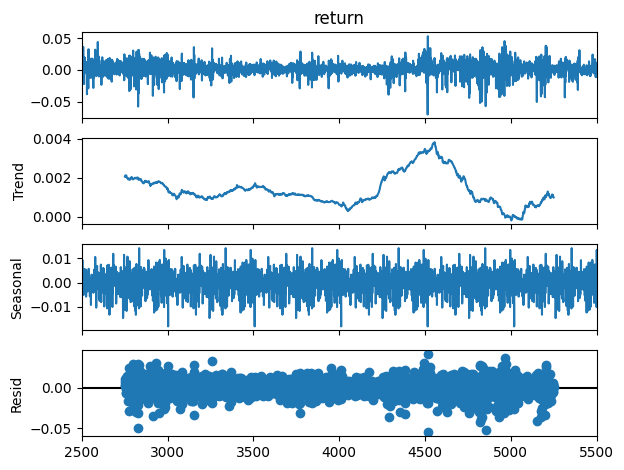

ic| i: 'HSX'


'HSX'

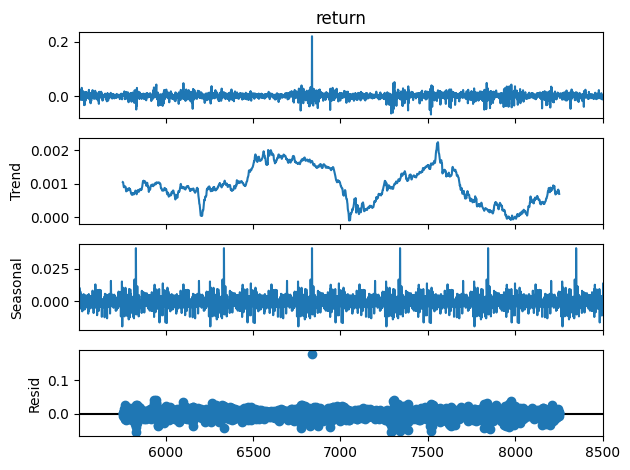

ic| i: 'UPCOM'


'UPCOM'

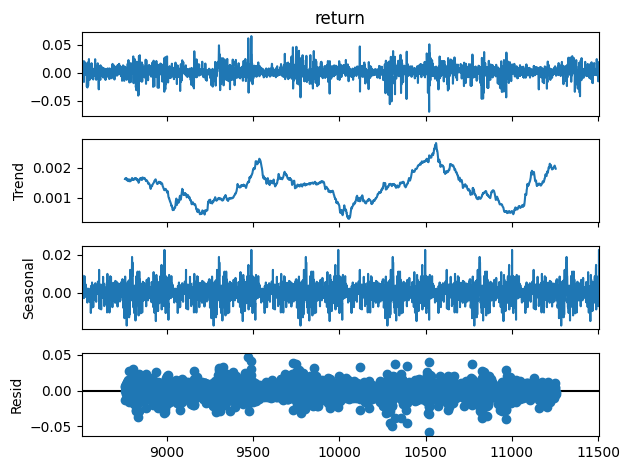

ic| i: 'vn30'


'vn30'

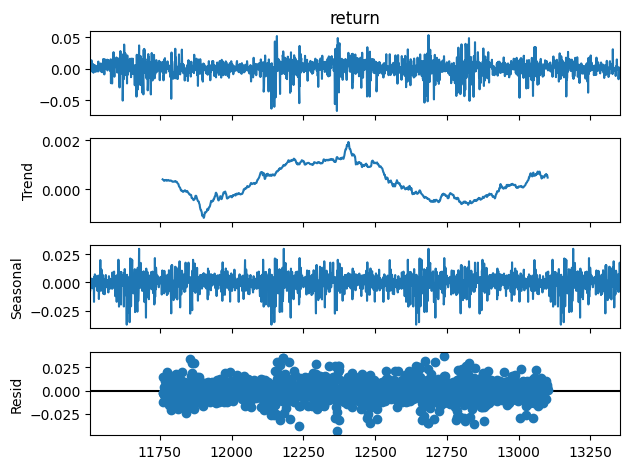

ic| i: 'vni'


'vni'

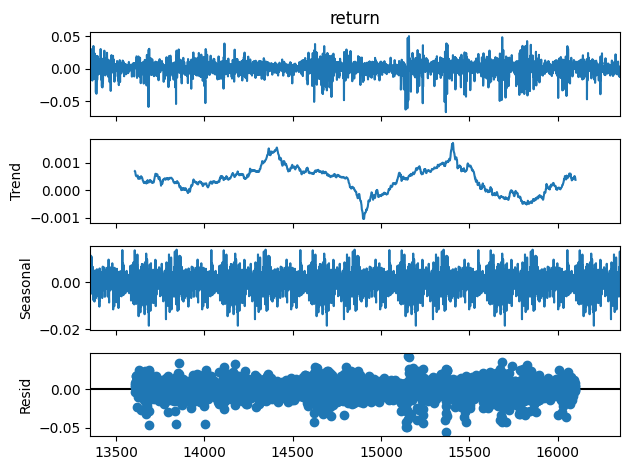

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

period = 1
for i in market["ticker"].unique():
    if i not in ["BOND", "DELISTED"]:
        ic(i)
        try:
            temp = market[market["ticker"] == i]["return"]
            result = seasonal_decompose(temp, model="additive", period=period * 252 * 2)
            result.plot()
            plt.close()
        except ValueError:
            print("plot 1 year cycles")
            result = seasonal_decompose(temp, model="additive", period=period * 252)
            result.plot()
            plt.close()

HSX


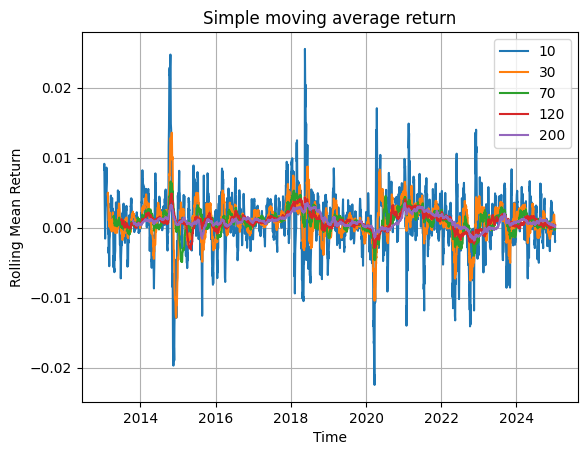

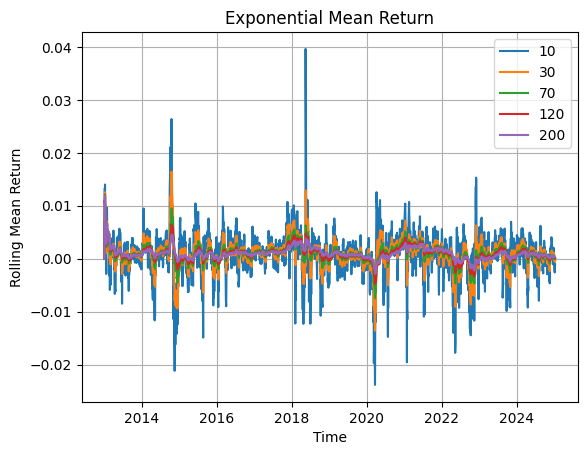

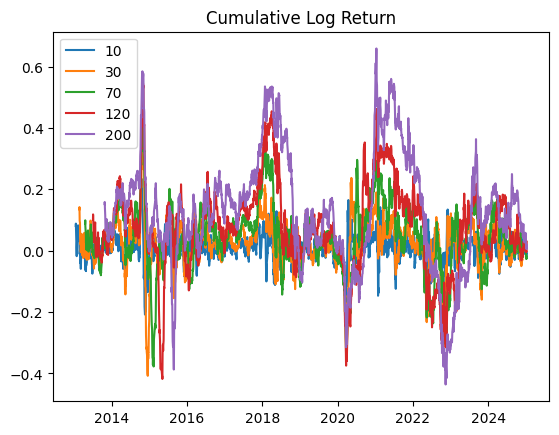

vn30


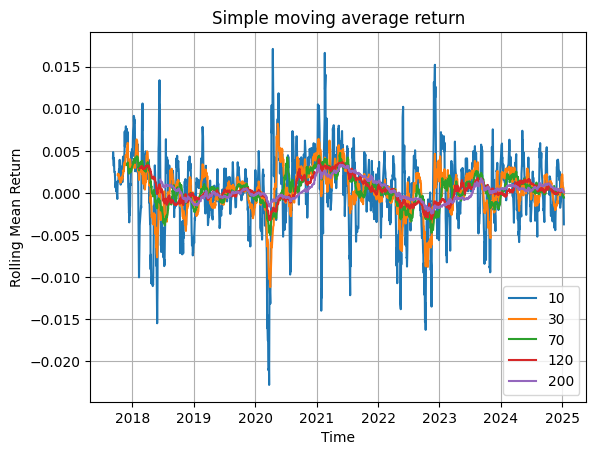

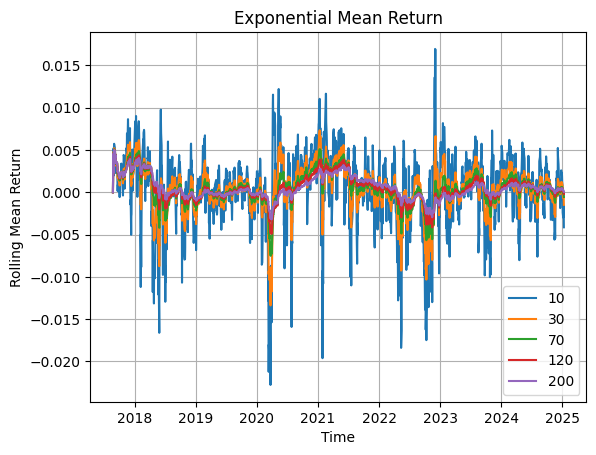

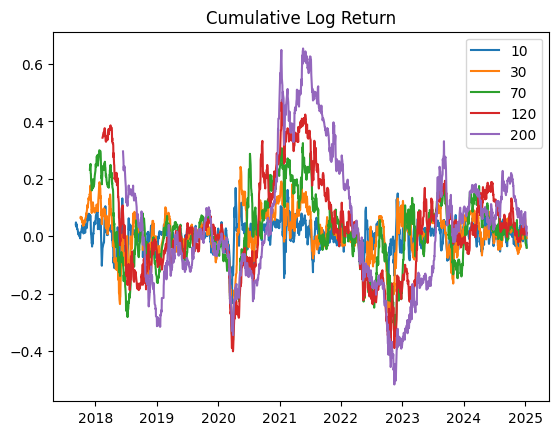

vni


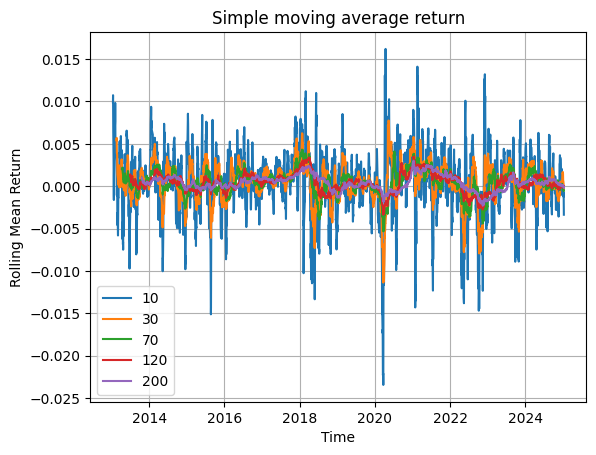

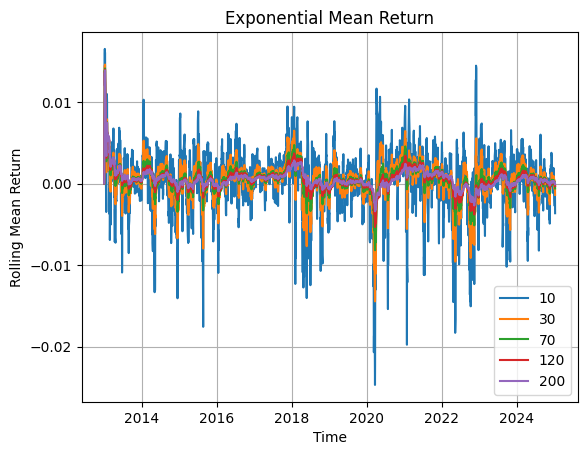

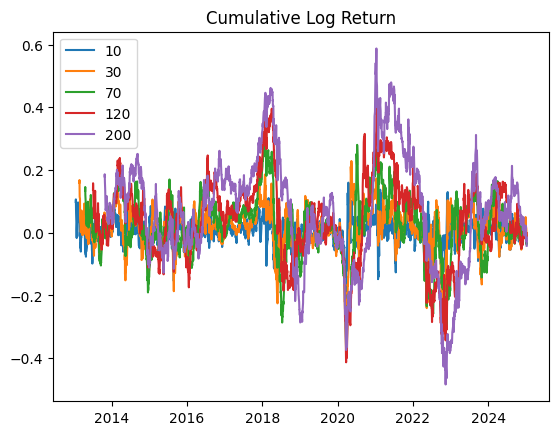

In [9]:
windows = [10, 30, 70, 120, 200]  # number of trading dates
for i in market["ticker"].unique():
    if i in ["HSX", "vni", "vn30"]:
        temp = market[market["ticker"] == i].copy()
        print(i)
        simple_moving_average_visual(temp, "return", windows)
        exponential_moving_average_visual(temp, "return", windows)
        cumulative_visual(temp, "log_return", windows)

# Auto Regression

'HSX'

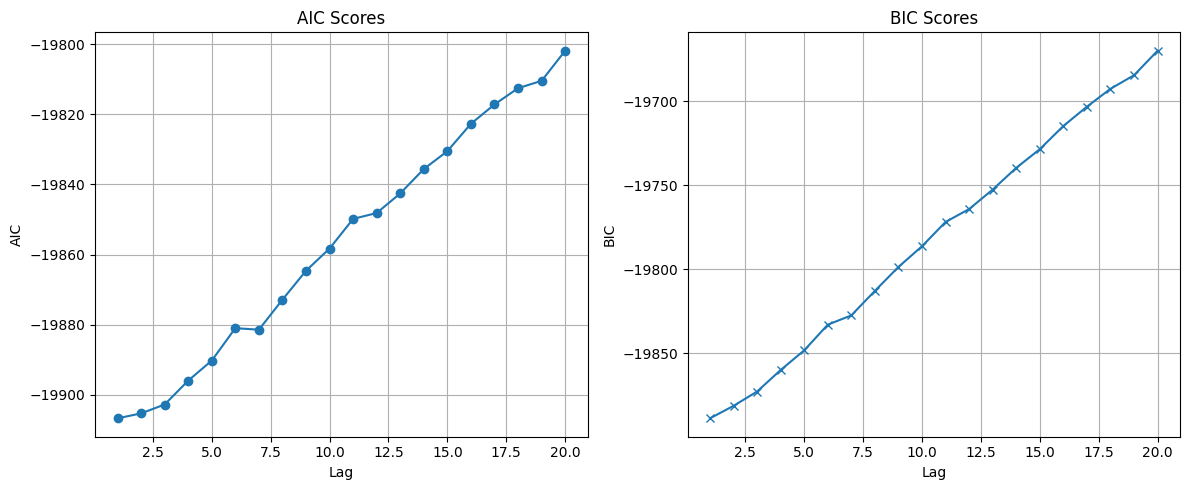

{'best_aic_lag': (1, np.float64(-19906.742574094318)),
 'best_bic_lag': (1, np.float64(-19888.72147205774))}

ic| min_mse_index:         mse  code
                   0  0.000086    13
    min_mape_index:        mape  code
                    0  1.562202     2


'vn30'

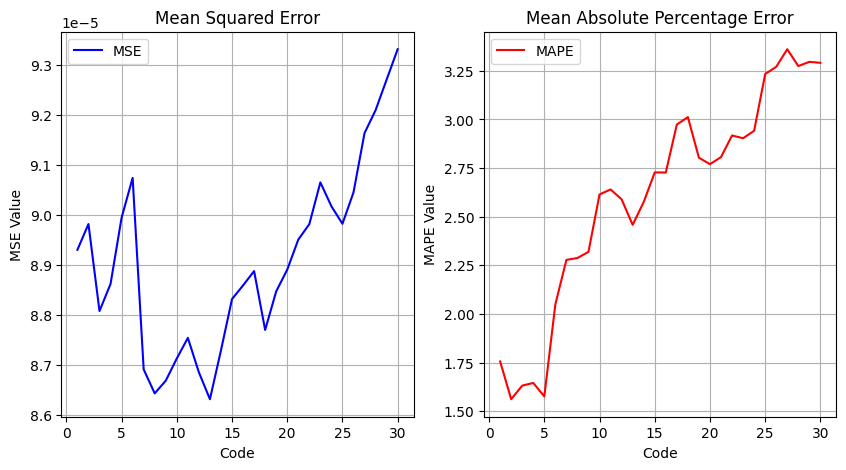

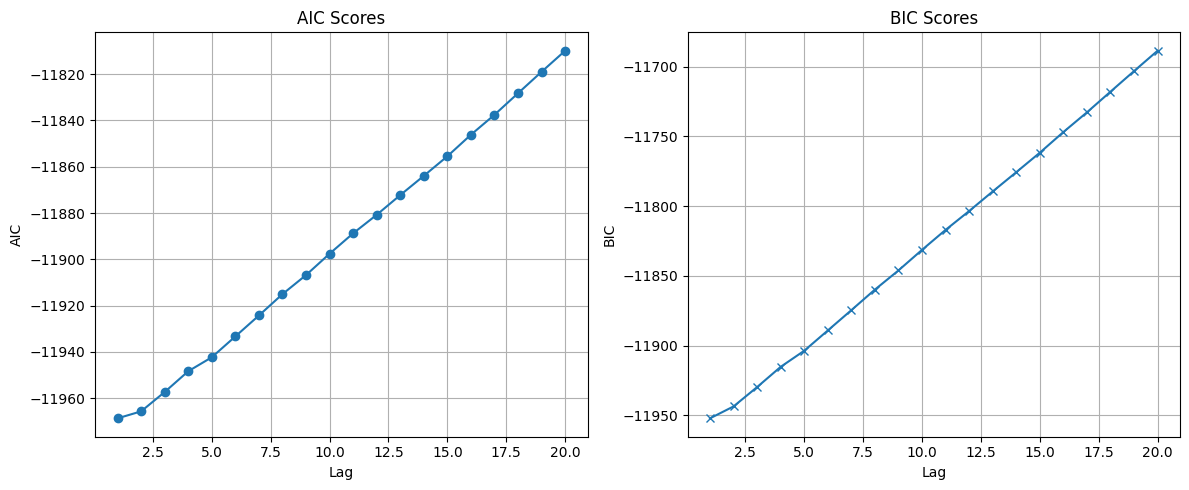

{'best_aic_lag': (1, np.float64(-11968.769974547075)),
 'best_bic_lag': (1, np.float64(-11952.20927087765))}

ic| min_mse_index:         mse  code
                   0  0.000066     3
    min_mape_index:        mape  code
                    0  1.229437     1


'vni'

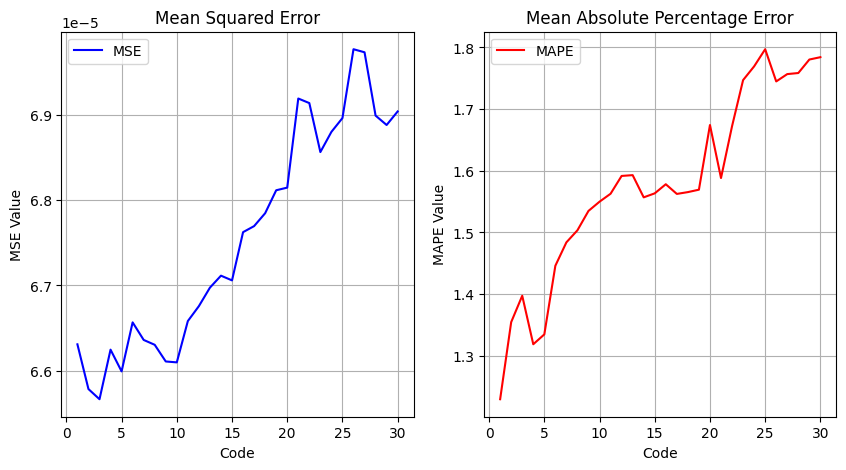

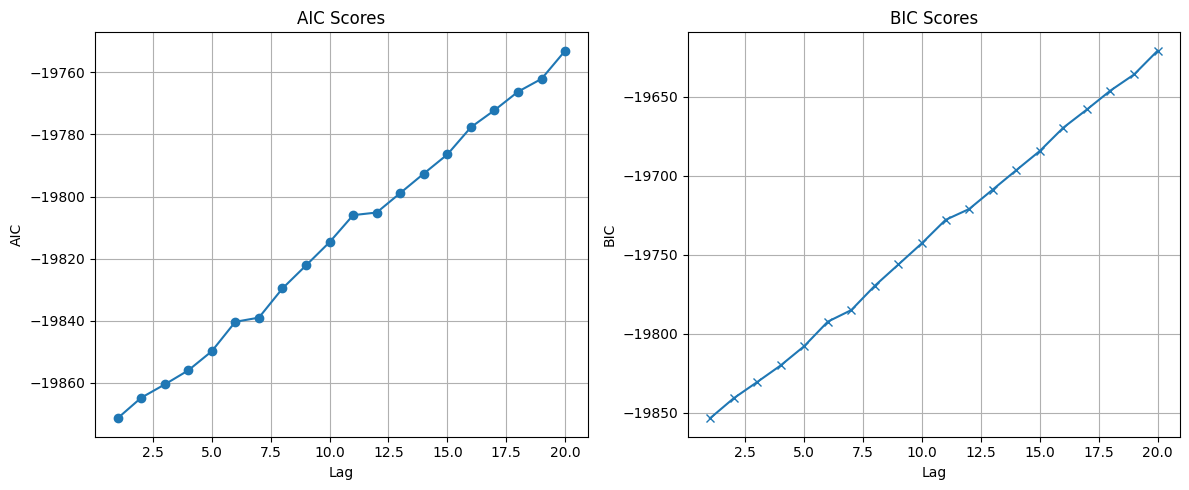

{'best_aic_lag': (1, np.float64(-19871.466905416815)),
 'best_bic_lag': (1, np.float64(-19853.448802880568))}

ic| min_mse_index:         mse  code
                   0  0.000081     7
    min_mape_index:        mape  code
                    0  1.158227     1


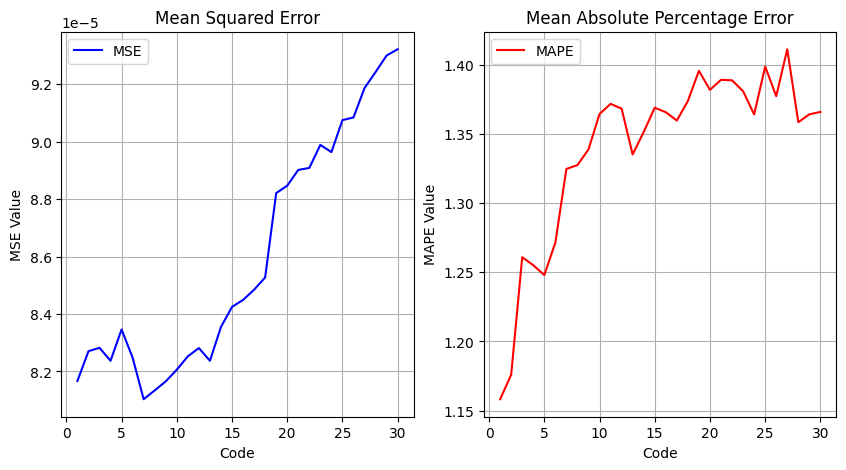

In [10]:
from AR import *

for i in market["ticker"].unique():
    if i in ["HSX", "vni", "vn30"]:
        i
        data = market_winsored[market_winsored["ticker"] == i]
        data.index = pd.date_range(
            start=data["time"].min(),
            periods=len(data),
            freq="B",
        )
        info_criteria_selection(data["return"])
        # using mean_squared_error
        result_return = plot_best_lag_model(data["return"])

'vni'

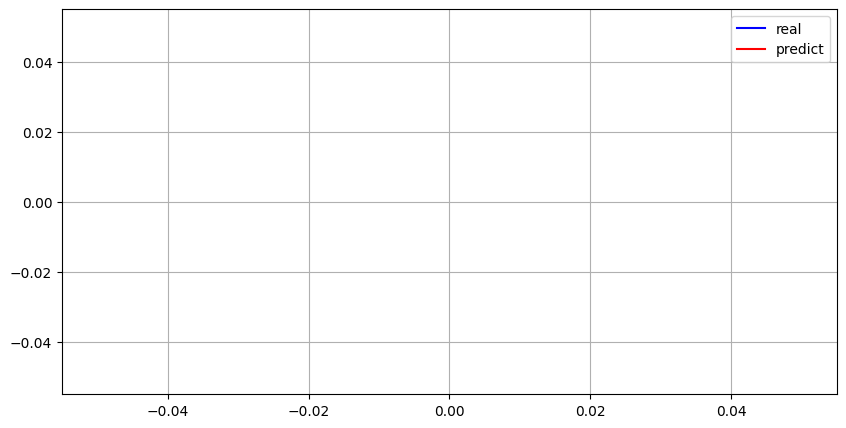

'HSX'

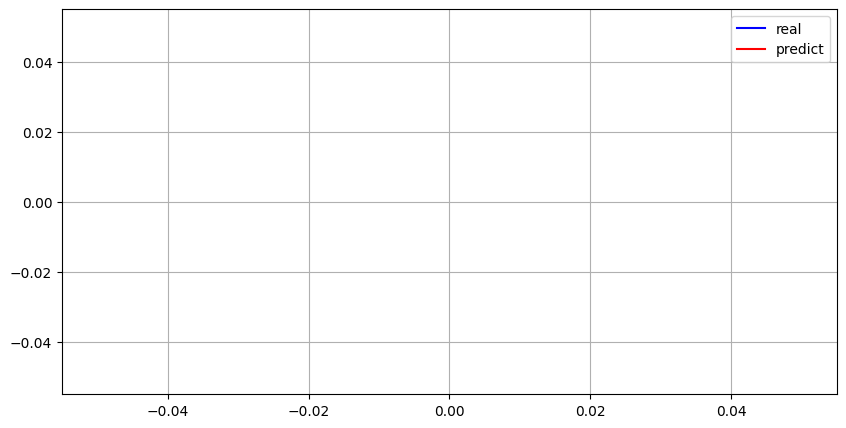

'vn30'

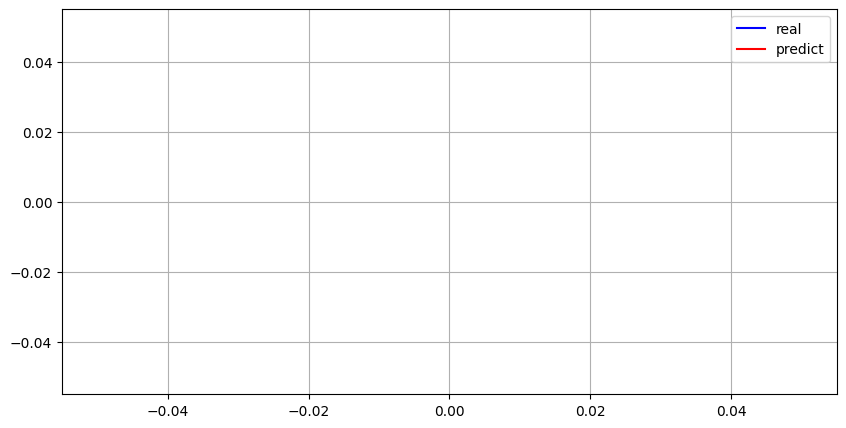

In [11]:
import numpy as np

for i in ["vni", "HSX", "vn30"]:
    i
    visualize(
        np.asarray(market_winsored[market_winsored["exchange"] == i]["return"]),
        1,
    )

## MA modeling

In [12]:
from MA import *

'HSX'

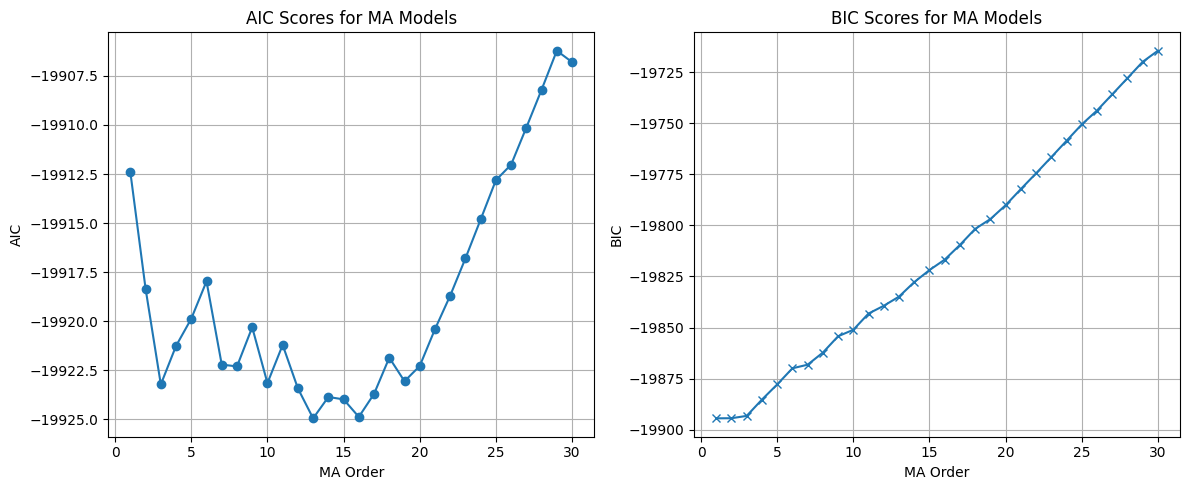

{'best_aic_order': (13, np.float64(-19924.95742745469)),
 'best_bic_order': (1, np.float64(-19894.38579407702))}

'vn30'

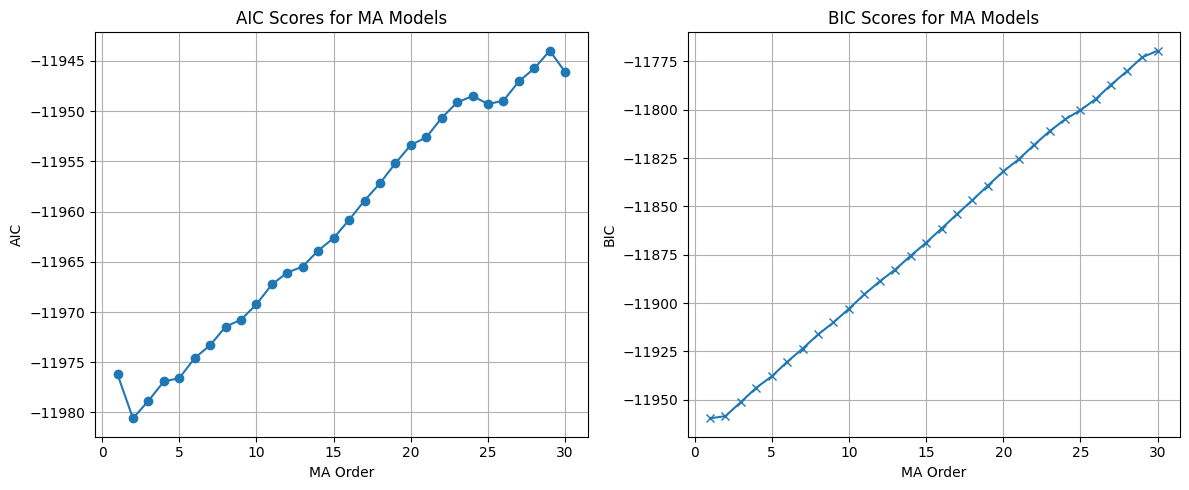

{'best_aic_order': (2, np.float64(-11980.590436706498)),
 'best_bic_order': (1, np.float64(-11959.654521197539))}

'vni'

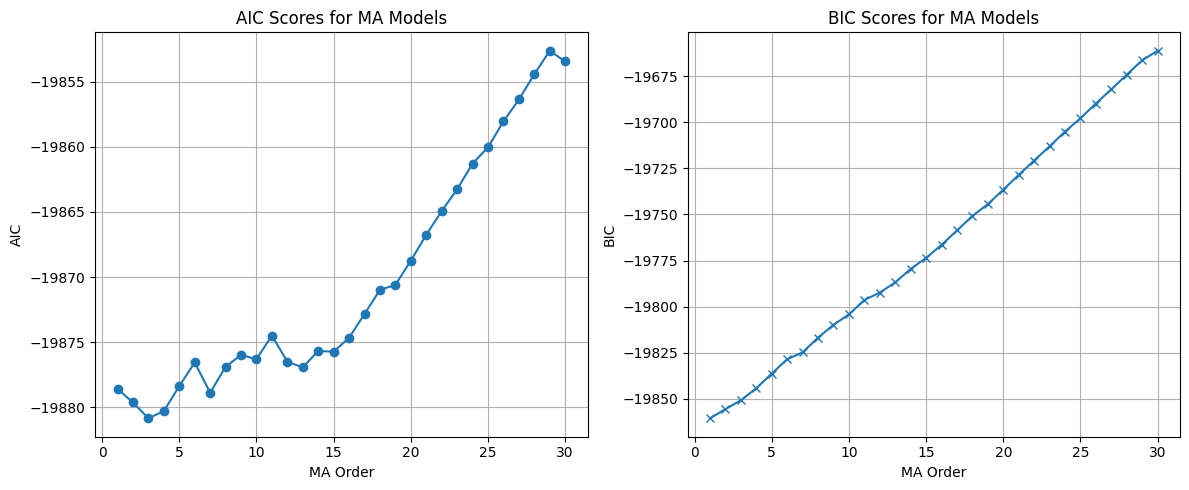

{'best_aic_order': (3, np.float64(-19880.846514990888)),
 'best_bic_order': (1, np.float64(-19860.573772019994))}

In [13]:
for i in market["ticker"].unique():
    if i in ["HSX", "vni", "vn30"]:
        i
        data = market_winsored[market_winsored["ticker"] == i]
        data.index = pd.date_range(
            start=data["time"].min(),
            periods=len(data),
            freq="B",
        )
        info_criteria_selection_ma(data["return"])

'HSX'

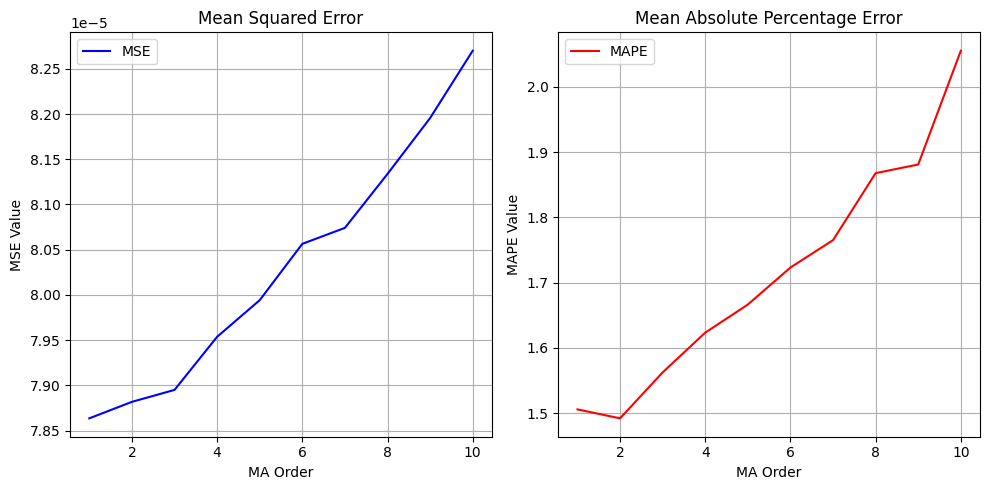

        mse  order
0  0.000079      1        mape  order
0  1.491997      2


mse      mape  order
0  0.000079  1.505708      1
0  0.000079  1.491997      2
0  0.000079  1.562393      3
0  0.000080  1.623346      4
0  0.000080  1.666373      5
0  0.000081  1.723174      6
0  0.000081  1.765095      7
0  0.000081  1.867811      8
0  0.000082  1.881068      9
0  0.000083  2.055460     10

'vn30'

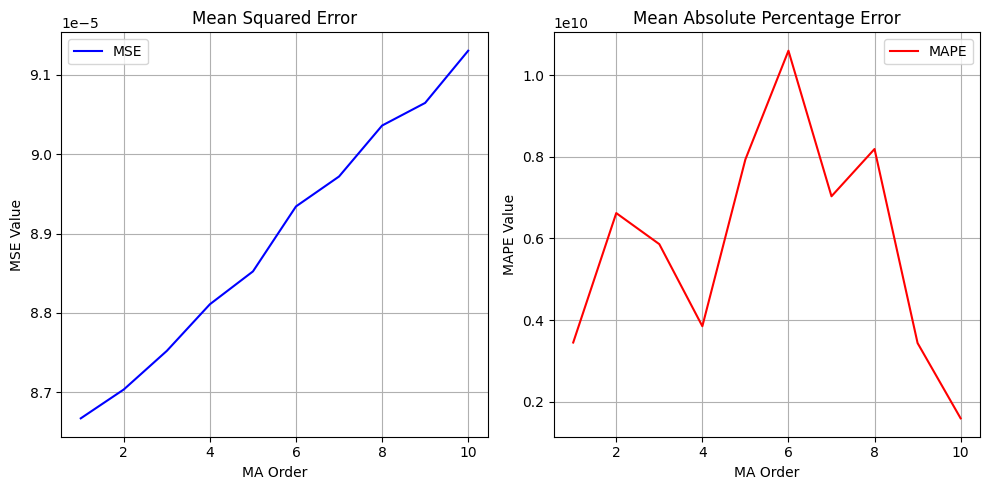

        mse  order
0  0.000087      1            mape  order
0  1.593024e+09     10


mse          mape  order
0  0.000087  3.450670e+09      1
0  0.000087  6.622616e+09      2
0  0.000088  5.861694e+09      3
0  0.000088  3.850201e+09      4
0  0.000089  7.937928e+09      5
0  0.000089  1.060136e+10      6
0  0.000090  7.034283e+09      7
0  0.000090  8.192724e+09      8
0  0.000091  3.437374e+09      9
0  0.000091  1.593024e+09     10

'vni'

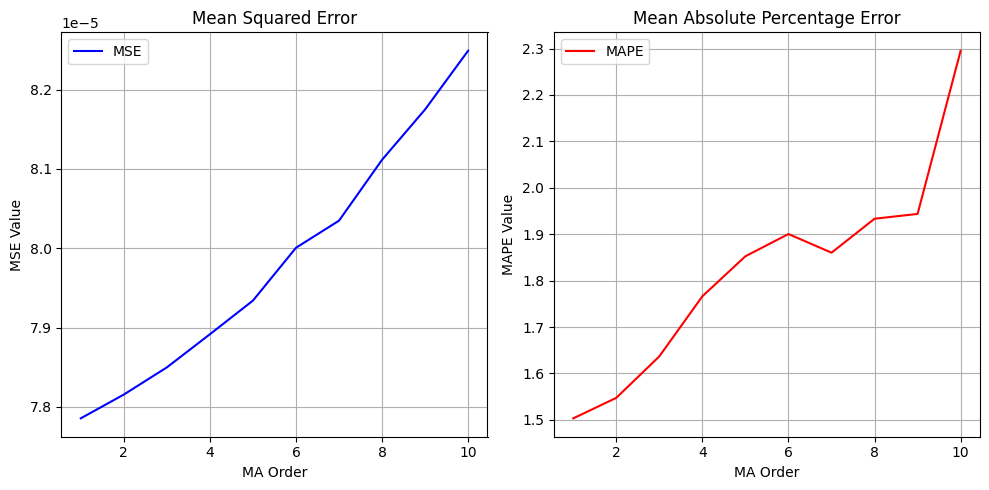

        mse  order
0  0.000078      1        mape  order
0  1.503347      1


mse      mape  order
0  0.000078  1.503347      1
0  0.000078  1.547480      2
0  0.000078  1.636930      3
0  0.000079  1.766362      4
0  0.000079  1.852588      5
0  0.000080  1.900434      6
0  0.000080  1.860229      7
0  0.000081  1.933379      8
0  0.000082  1.943744      9
0  0.000082  2.295360     10

In [14]:
for i in market["ticker"].unique():
    if i in ["HSX", "vni", "vn30"]:
        i
        data = market_winsored[market_winsored["ticker"] == i]
        data.index = pd.date_range(
            start=data["time"].min(),
            periods=len(data),
            freq="B",
        
        plot_best_ma_model(data["return"])

'HSX'

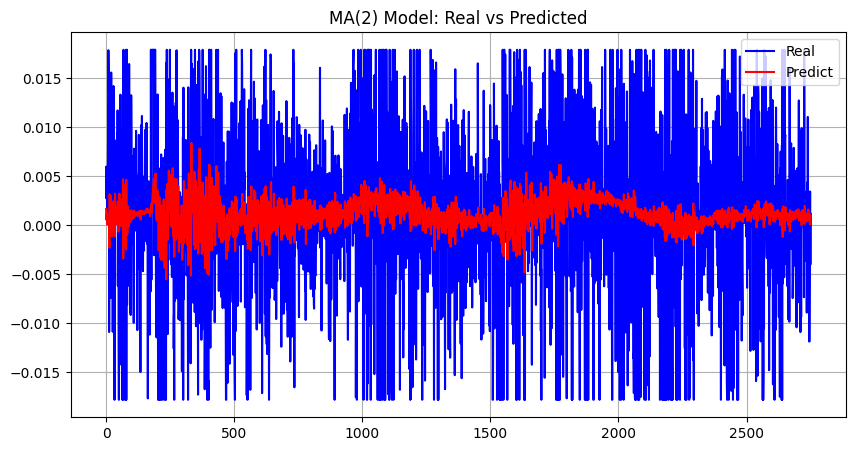

'vn30'

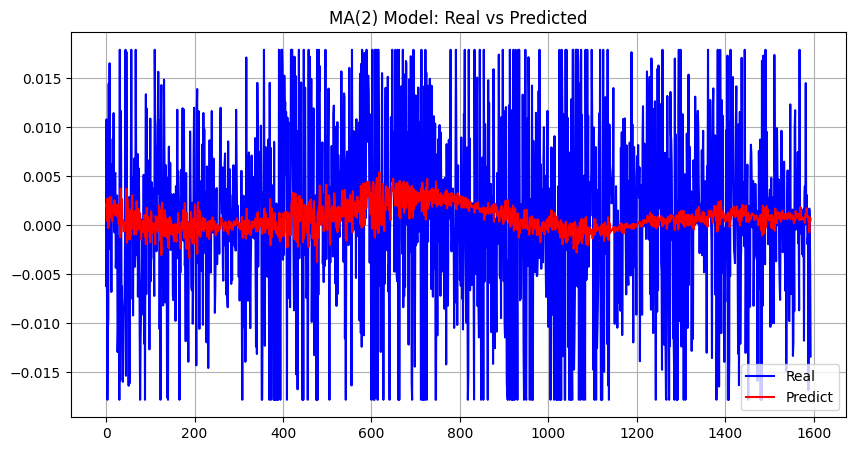

'vni'

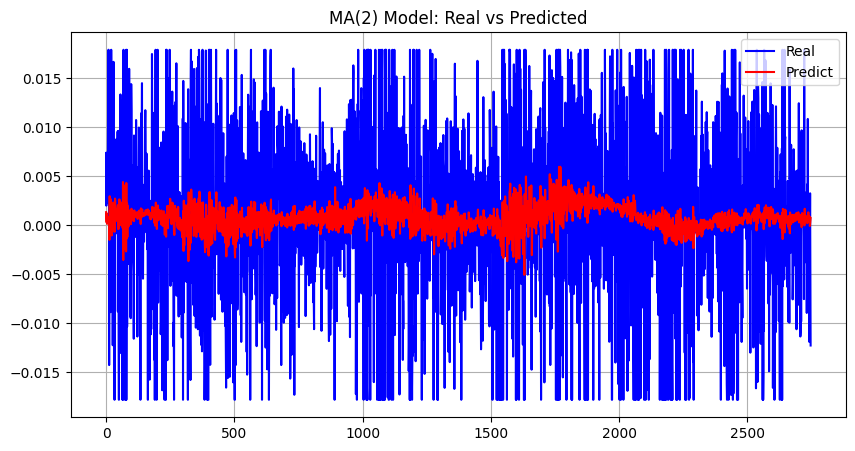

In [15]:
for i in market["ticker"].unique():
    if i in ["HSX", "vni", "vn30"]:
        i
        data = market_winsored[market_winsored["ticker"] == i]
        data.index = pd.date_range(
            start=data["time"].min(),
            periods=len(data),
            freq="B",
        )
        visualize_ma(
            np.asarray(data["return"]),
            2,
        )

* Both of AR and MA model give bad predictions, when we use more lag the shape of the red predict line might be more similar to real but the MSE and MAPE backtest value would be larger due to mis-match in the time.


## ARIMA model for model predicting

In [16]:
from arima import *

'HSX'

Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimati

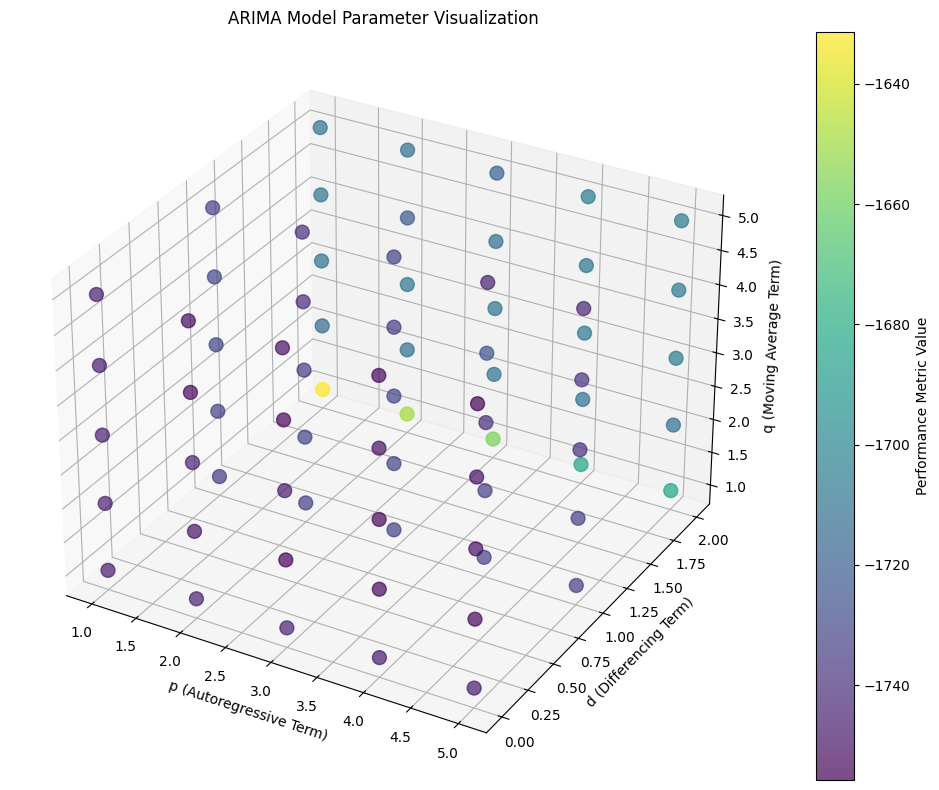

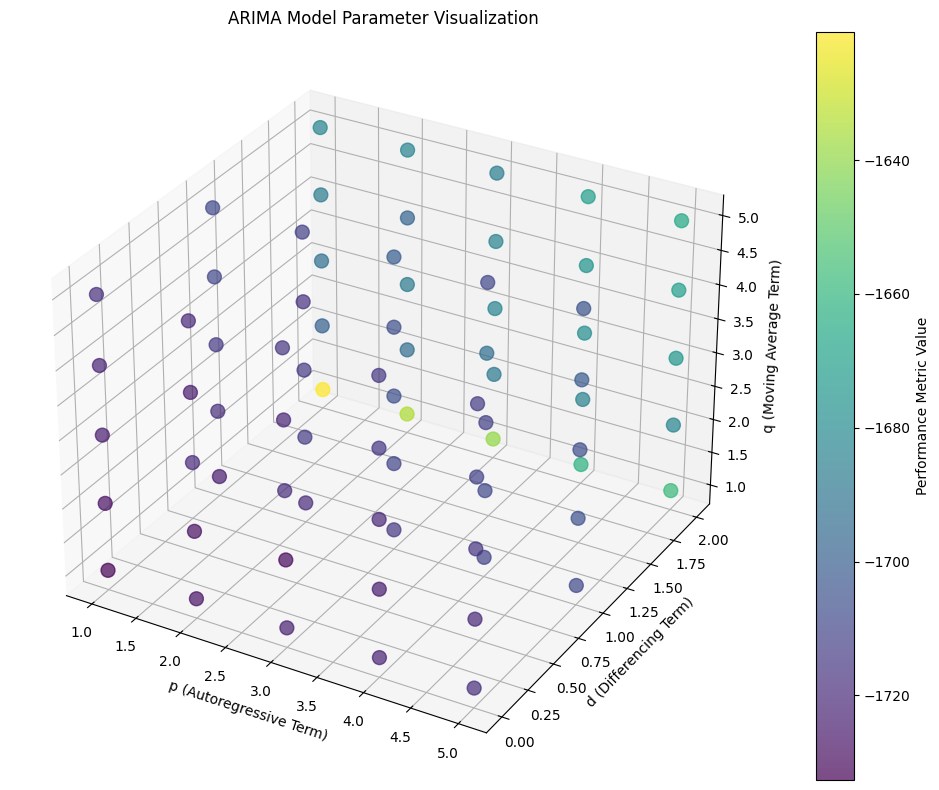

{'best_aic_order': ((5, 0, 5), np.float64(-1755.7377134057292)),
 'best_bic_order': ((5, 0, 5), np.float64(-1755.7377134057292))}

'vn30'

Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimati

(5, 1, 3) fail to converge and eliminated


Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".


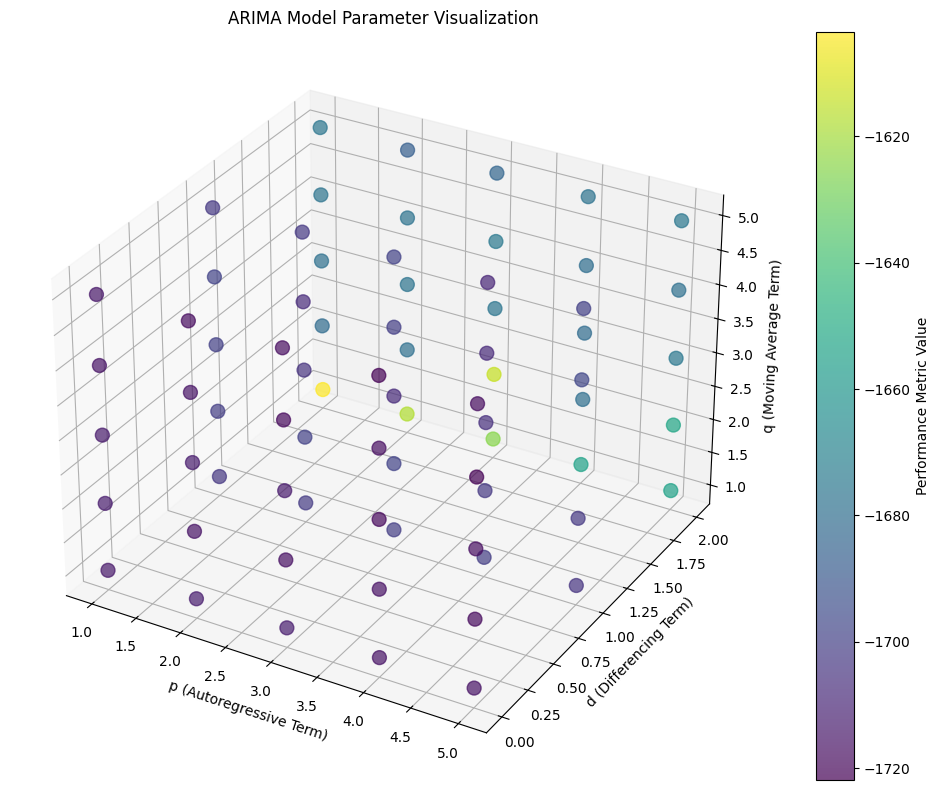

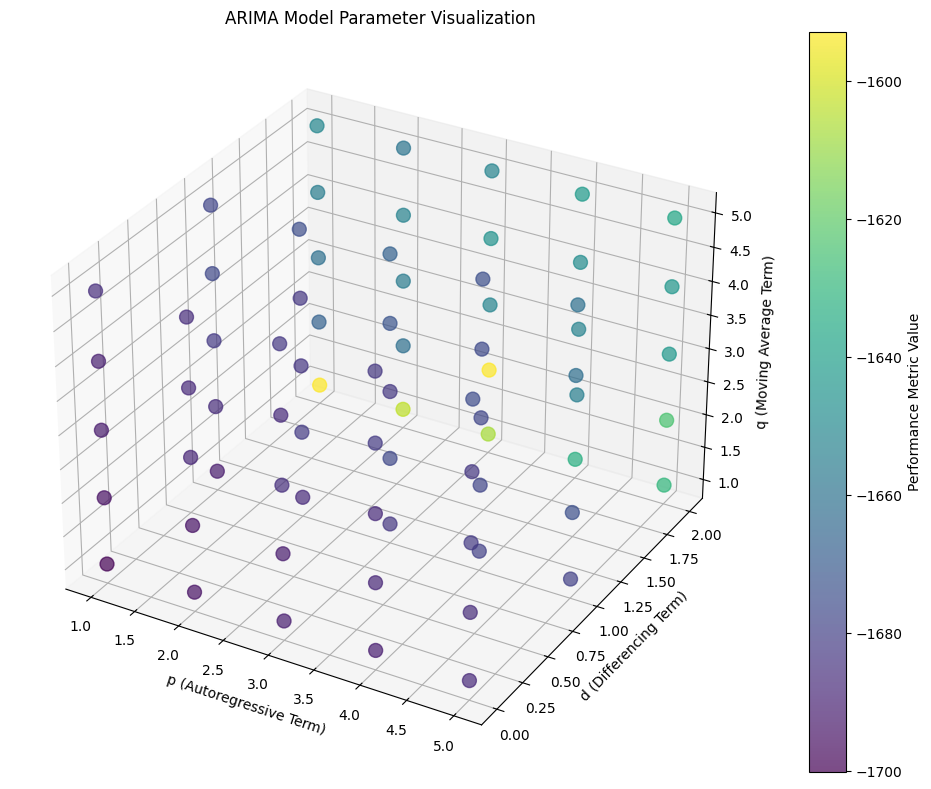

{'best_aic_order': ((5, 0, 4), np.float64(-1721.8693330866322)),
 'best_bic_order': ((5, 0, 4), np.float64(-1721.8693330866322))}

'vni'

Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
Provided `endog` series has been differenced to eliminate integration prior to parameter estimati

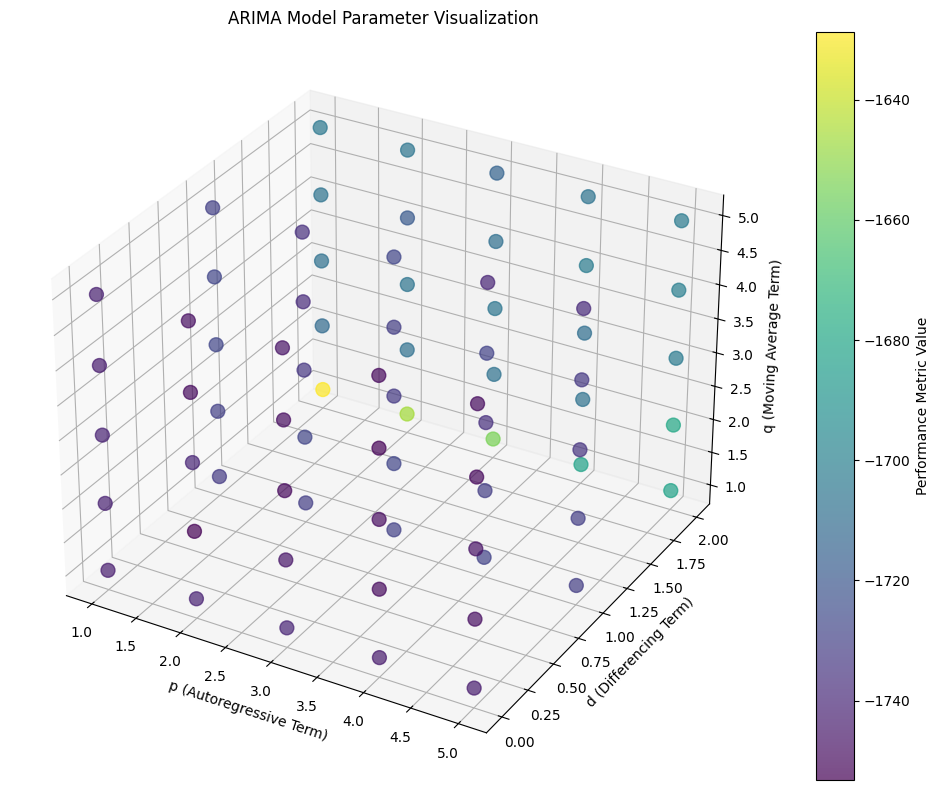

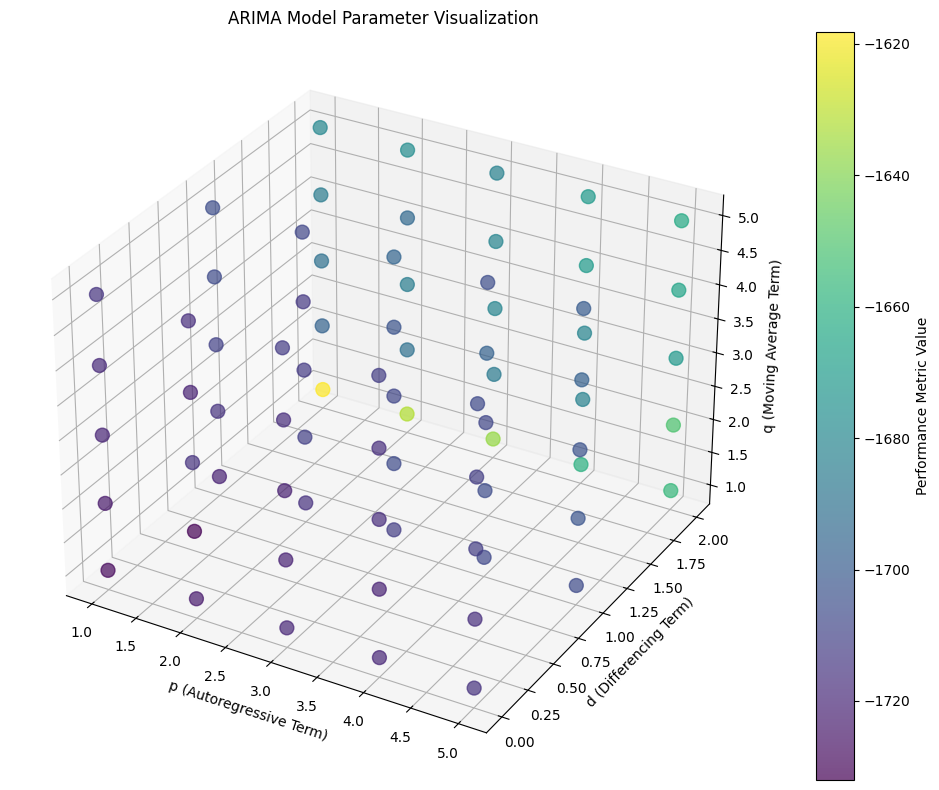

{'best_aic_order': ((2, 0, 2), np.float64(-1753.2117316430872)),
 'best_bic_order': ((2, 0, 2), np.float64(-1753.2117316430872))}

In [17]:
for i in market_winsored["ticker"].unique():
    if i in ["HSX", "vni", "vn30"]:
        i
        data = market_winsored[market_winsored["ticker"] == i]
        data.index = pd.date_range(
            start=data["time"].min(),
            periods=len(data),
            freq="B",
        )
        info_criteria_selection_arima(data["log_return"], [5, 2, 5])

In [18]:
data = market_winsored[market_winsored["ticker"] == "HSX"]
data.index = pd.date_range(
    start=data["time"].min(),
    periods=len(data),
    freq="B",
)

'HSX'

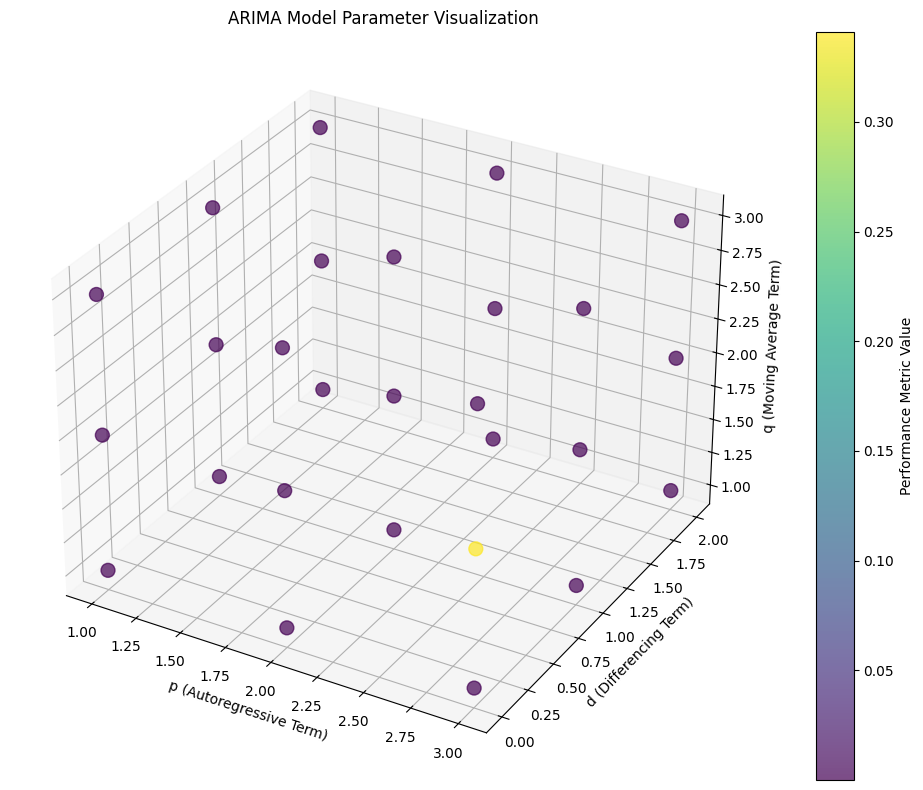

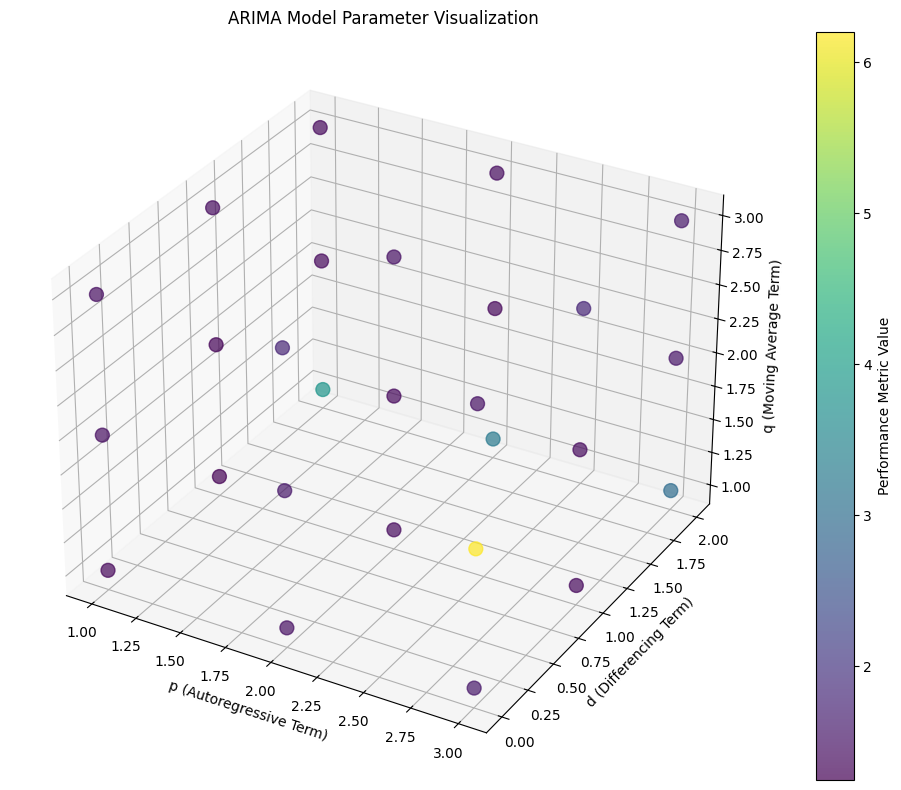

        mse      order
0  0.000057  (3, 1, 2)        mape      order
0  1.248127  (1, 1, 1)


mse      mape      order
0  0.000058  1.331341  (1, 0, 1)
0  0.000058  1.423820  (1, 0, 2)
0  0.000058  1.435167  (1, 0, 3)
0  0.000058  1.248127  (1, 1, 1)
0  0.000058  1.283574  (1, 1, 2)
0  0.000058  1.400526  (1, 1, 3)
0  0.000086  3.837259  (1, 2, 1)
0  0.000059  1.361526  (1, 2, 2)
0  0.000059  1.362069  (1, 2, 3)
0  0.000058  1.449245  (2, 0, 1)
0  0.000058  1.559516  (2, 0, 2)
0  0.000060  1.754735  (2, 0, 3)
0  0.000058  1.369080  (2, 1, 1)
0  0.000061  1.351026  (2, 1, 2)
0  0.000058  1.468072  (2, 1, 3)
0  0.000078  3.257775  (2, 2, 1)
0  0.000060  1.332348  (2, 2, 2)
0  0.000059  1.384601  (2, 2, 3)
0  0.000058  1.559993  (3, 0, 1)
0  0.340781  6.197184  (3, 0, 2)
0  0.000060  1.462352  (3, 0, 3)
0  0.000058  1.359470  (3, 1, 1)
0  0.000057  1.380202  (3, 1, 2)
0  0.000060  1.779696  (3, 1, 3)
0  0.000074  2.973590  (3, 2, 1)
0  0.000065  1.535636  (3, 2, 2)
0  0.000060  1.567213  (3, 2, 3)

'vni'

value error order(3, 0, 2), start_index:236, :488


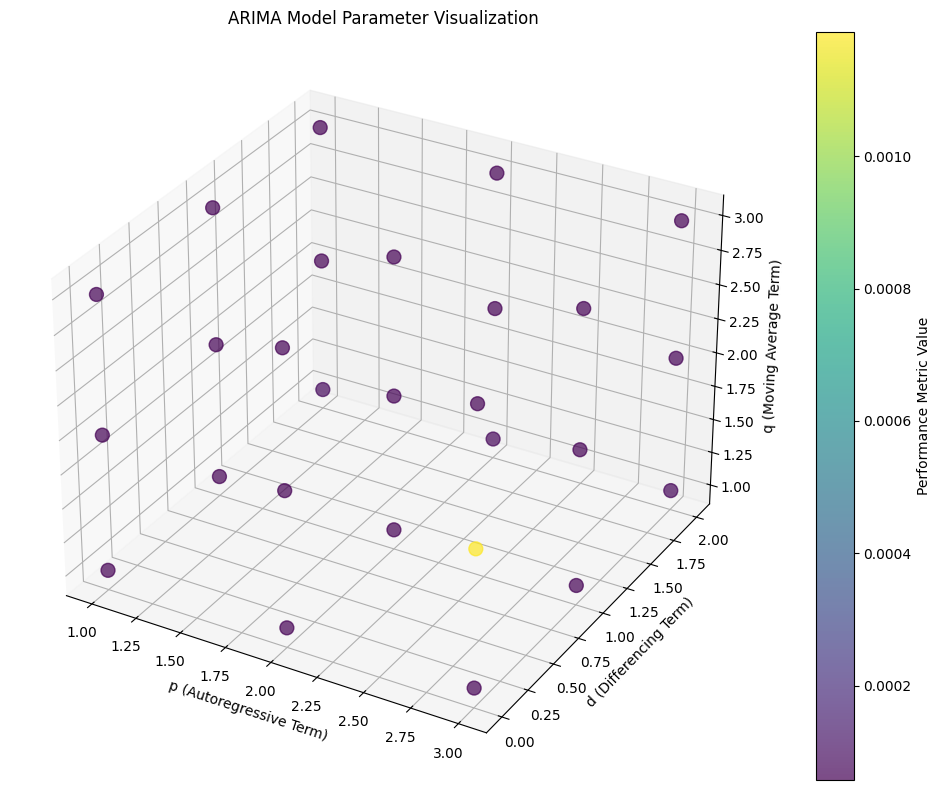

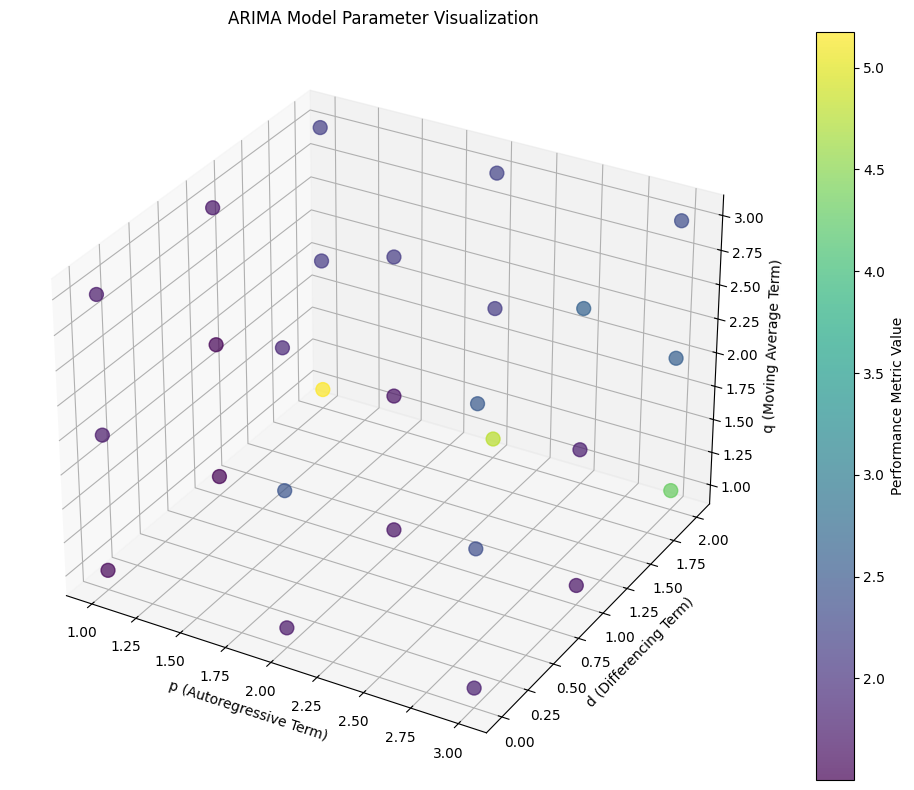

        mse      order
0  0.000058  (3, 1, 2)       mape      order
0  1.50149  (1, 1, 1)


mse      mape      order
0  0.000058  1.534451  (1, 0, 1)
0  0.000058  1.721696  (1, 0, 2)
0  0.000059  1.726032  (1, 0, 3)
0  0.000058  1.501490  (1, 1, 1)
0  0.000058  1.514785  (1, 1, 2)
0  0.000058  1.690335  (1, 1, 3)
0  0.000086  5.172929  (1, 2, 1)
0  0.000059  2.114973  (1, 2, 2)
0  0.000061  2.165902  (1, 2, 3)
0  0.000059  1.693984  (2, 0, 1)
0  0.000059  2.457778  (2, 0, 2)
0  0.000059  1.870924  (2, 0, 3)
0  0.000058  1.662879  (2, 1, 1)
0  0.000062  1.654851  (2, 1, 2)
0  0.000059  2.118983  (2, 1, 3)
0  0.000079  4.777368  (2, 2, 1)
0  0.000060  2.134697  (2, 2, 2)
0  0.000061  2.205580  (2, 2, 3)
0  0.000059  1.782448  (3, 0, 1)
0  0.001187  2.353218  (3, 0, 2)
0  0.000061  2.506744  (3, 0, 3)
0  0.000058  1.670526  (3, 1, 1)
0  0.000058  1.754324  (3, 1, 2)
0  0.000059  2.626428  (3, 1, 3)
0  0.000074  4.308877  (3, 2, 1)
0  0.000065  2.590293  (3, 2, 2)
0  0.000060  2.339173  (3, 2, 3)

In [19]:
for i in market_winsored["ticker"].unique():
    if i in ["vni", "HSX"]:
        i
        data = market_winsored[market_winsored["ticker"] == i]
        data.index = pd.date_range(
            start=data["time"].min(),
            periods=len(data),
            freq="B",
        )
        plot_best_arima_model(data["return"][-550:], (3, 2, 3))